In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os, os.path
from scipy import interpolate
import galpy.df
from galpy.orbit import Orbit
from galpy.potential import LogarithmicHaloPotential
from galpy.actionAngle import actionAngleIsochroneApprox, estimateBIsochrone
from galpy.df import streamdf
from galpy.util import bovy_plot, bovy_coords, bovy_conversion #for unit conversions
from gd1_util import R0, V0
import custom_stripping_df
from matplotlib.ticker import NullFormatter
nullfmt= NullFormatter()
import matplotlib.lines as mlines
from matplotlib import gridspec
import seaborn as sns
%pylab inline
sns.set_style('ticks',
              {'xtick.direction': u'in',
               'ytick.direction': u'in',
               'axes.labelsize': 18.0,
               'axes.titlesize': 18.0,
               'figure.figsize': array([ 6.64,  4.  ]),
               'grid.linewidth': 2.0,
               'legend.fontsize': 18.0,
               'lines.linewidth': 2.0,
               'lines.markeredgewidth': 0.0,
               'lines.markersize': 14.0,
               'patch.linewidth': 0.6,
               'xtick.labelsize': 16.0,
               'xtick.major.pad': 14.0,
               'xtick.major.width': 2.0,
               'xtick.minor.width': 1.0,
               'ytick.labelsize': 16.0,
               'ytick.major.pad': 14.0,
               'ytick.major.width': 2.0,})
save_figures= True

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# Comparison to $N$-body simulations

In [3]:
lp= LogarithmicHaloPotential(normalize=1.,q=0.9)
aAI= actionAngleIsochroneApprox(pot=lp,b=0.8)
# Convenience function
def convert_to_cylindrical(xv):
    R,phi,Z= bovy_coords.rect_to_cyl(xv[:,0],xv[:,1],xv[:,2])
    vR,vT,vZ= bovy_coords.rect_to_cyl_vec(xv[:,3],xv[:,4],xv[:,5],R,phi,Z,cyl=True)
    out= numpy.empty_like(xv)
    # Preferred galpy arrangement of cylindrical coordinates
    out[:,0]= R
    out[:,1]= vR
    out[:,2]= vT
    out[:,3]= Z
    out[:,4]= vZ
    out[:,5]= phi
    return out
# Progenitor
xv_prog_init= numpy.array([30.,0.,0.,0., 105.74895, 105.74895])
RvR_prog_init= convert_to_cylindrical(xv_prog_init[:,numpy.newaxis].T)[0,:]
prog_init= Orbit([RvR_prog_init[0]/R0,RvR_prog_init[1]/V0,RvR_prog_init[2]/V0,
                  RvR_prog_init[3]/R0,RvR_prog_init[4]/V0,RvR_prog_init[5]],ro=R0,vo=V0)
times= numpy.linspace(0.,10.88/bovy_conversion.time_in_Gyr(V0,R0),1001)
prog_init.integrate(times,lp)
xv_unp_peri_prog= [prog_init.x(times[-1]),prog_init.y(times[-1]),prog_init.z(times[-1]),
              prog_init.vx(times[-1]),prog_init.vy(times[-1]),prog_init.vz(times[-1])]
RvR_unp_peri_prog= convert_to_cylindrical(numpy.array(xv_unp_peri_prog)[:,numpy.newaxis].T)[0,:]
prog_unp_peri= Orbit([RvR_unp_peri_prog[0]/R0,RvR_unp_peri_prog[1]/V0,RvR_unp_peri_prog[2]/V0,
                      RvR_unp_peri_prog[3]/R0+0.0,RvR_unp_peri_prog[4]/V0,RvR_unp_peri_prog[5]])

In [4]:
def plot_single_comparison(xv_unp_peri,xv_1e6_peri,
                           xv_mock_unp,xv_mock_per,xv_mock_per_onlyopar,
                           log10mass,alpha=0.1):
    scale= 10.**(0.6*(log10mass-6.))
    gs=  gridspec.GridSpec(2,3,height_ratios=[1.,1.],hspace=0.2,wspace=0.35)
    gs2= gridspec.GridSpec(2,3,height_ratios=[1.,1.],hspace=0.2,wspace=0.35)
    subplot(gs2[0])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,0]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',color=sns.color_palette()[3],
                        ylabel=r'$\delta x/\mathrm{kpc}$',gcf=True,yrange=[-.15*scale,.15*scale],
                       xrange=[-5.,15.])
    plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e6_peri[(xv_unp_peri[:,1] < 5.),0]
         -xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,0]-xv_mock_unp[:,0])*R0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per_onlyopar[:,0]-xv_mock_unp[:,0])*R0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    bovy_plot.bovy_text(r'$M = 10^%i\,M_\odot$' % log10mass,size=18.,top_left=True)
    subplot(gs2[1])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,0]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',color=sns.color_palette()[3],
                        ylabel=r'$\delta y/\mathrm{kpc}$',gcf=True,yrange=[-.05*scale,.05*scale],
                       xrange=[-5.,15.])
    plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e6_peri[(xv_unp_peri[:,1] < 5.),1]
         -xv_unp_peri[(xv_unp_peri[:,1] < 5.),1],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,1]-xv_mock_unp[:,1])*R0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per_onlyopar[:,1]-xv_mock_unp[:,1])*R0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    l1= pyplot.legend((mlines.Line2D([], [], color='k',marker='o',ls='none'),
                       mlines.Line2D([], [], color=sns.color_palette()[2],marker='o',ls='none')),
                      (r'$\mathrm{Simulation}$',
                       r'$\mathrm{Model}$'),
                       loc='upper left',#bbox_to_anchor=(.02,.02),
                       numpoints=1,
                       prop={'size':20},
                       frameon=False)
    l2= pyplot.legend((mlines.Line2D([], [], color=sns.color_palette()[4],marker='o',ls='none'),),
                      (r'$\mathrm{Parallel\!\!-\!\!only\ model}$',),
                       loc='lower left',#bbox_to_anchor=(.02,.02),
                       numpoints=1,
                       prop={'size':20},
                       frameon=False)
    pyplot.gca().add_artist(l1)
    subplot(gs2[2])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,0]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',color=sns.color_palette()[3],
                        ylabel=r'$\delta z/\mathrm{kpc}$',gcf=True,yrange=[-.15*scale,.15*scale],
                       xrange=[-5.,15.])
    plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e6_peri[(xv_unp_peri[:,1] < 5.),2]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),2],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,2]-xv_mock_unp[:,2])*R0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per_onlyopar[:,2]-xv_mock_unp[:,2])*R0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    subplot(gs2[3])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,0]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[3],
                        ylabel=r'$\delta v_x/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-.75*scale,.75*scale],
                       xrange=[-5.,15.])
    plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e6_peri[(xv_unp_peri[:,1] < 5.),3]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),3],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,3]-xv_mock_unp[:,3])*V0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per_onlyopar[:,3]-xv_mock_unp[:,3])*V0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    subplot(gs2[4])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,0]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[3],
                        ylabel=r'$\delta v_y/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-2.*scale,2.*scale],
                       xrange=[-5.,15.])
    plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e6_peri[(xv_unp_peri[:,1] < 5.),4]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),4],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,4]-xv_mock_unp[:,4])*V0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per_onlyopar[:,4]-xv_mock_unp[:,4])*V0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    subplot(gs2[5])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,0]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[3],
                        ylabel=r'$\delta v_z/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-.75*scale,.75*scale],
                       xrange=[-5.,15.])
    plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e6_peri[(xv_unp_peri[:,1] < 5.),5]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),5],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,5]-xv_mock_unp[:,5])*V0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per_onlyopar[:,5]-xv_mock_unp[:,5])*V0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)

## $10^8\,M_\odot$

In [5]:
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_2nd_peri_unperturbed.txt'))
xv_unp_peri= xvid[:,:6]
xv_unp_peri= xv_unp_peri[numpy.argsort(xvid[:,6])]
RvR_unp_peri= convert_to_cylindrical(xv_unp_peri)
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_2nd_peri_1e8.txt'))
xv_1e8_peri= xvid[:,:6]
xv_1e8_peri= xv_1e8_peri[numpy.argsort(xvid[:,6])]
RvR_1e8_peri= convert_to_cylindrical(xv_1e8_peri)

In [6]:
sigv= 0.365*(10./2.)**(1./3.) # km/s, based on M^(1/3) scaling applied to 10^5 vs. 2x10^4 in my paper
sdf_smooth= \
    custom_stripping_df.streamdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                       leading=False,nTrackChunks=101,nTrackIterations=1,
                                       sigMeanOffset=4.5,
                                       tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                       Vnorm=V0,Rnorm=R0)
sdf_1e8= \
    custom_stripping_df.streamgapdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                          leading=False,nTrackChunks=101,nTrackIterations=1,
                                          nTrackChunksImpact=116,
                                          sigMeanOffset=4.5,
                                          tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          Vnorm=V0,Rnorm=R0,
                                          impactb=0.,
                                          subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0,
                                          timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          impact_angle=-2.34,
                                          GM=10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),
                                          rs=0.625/R0)
sdf_1e8_onlyopar= \
    custom_stripping_df.streamgapdf_jason_onlyopar(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                          leading=False,nTrackChunks=101,nTrackIterations=1,
                                          nTrackChunksImpact=116,
                                          sigMeanOffset=4.5,
                                          tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          Vnorm=V0,Rnorm=R0,
                                          impactb=0.,
                                          subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0,
                                          timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          impact_angle=-2.34,
                                          GM=10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),
                                          rs=0.625/R0)

In [7]:
numpy.random.seed(1)
xv_mock_unp= sdf_smooth.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per= sdf_1e8.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per_onlyopar= sdf_1e8_onlyopar.sample(n=100000,xy=True).T

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))



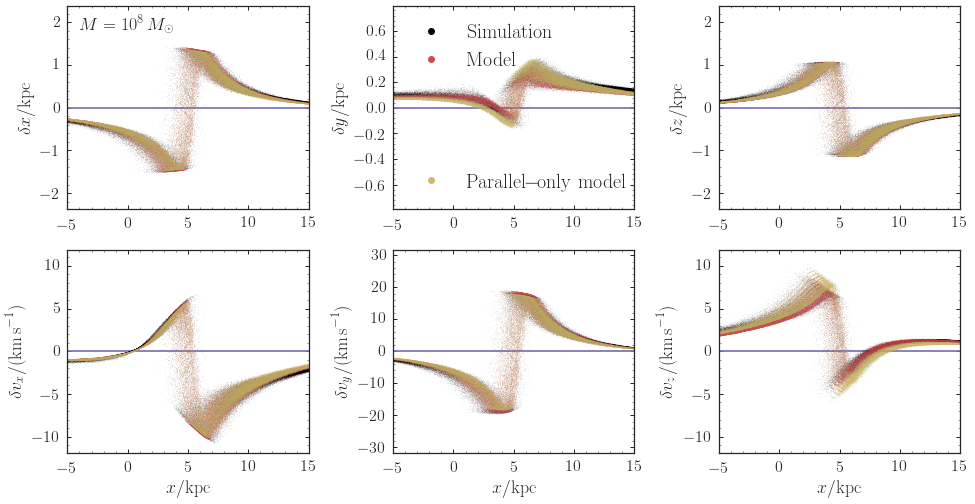

In [8]:
bovy_plot.bovy_print(axes_labelsize=18.,text_fontsize=12.,xtick_labelsize=16.,ytick_labelsize=16.)
figsize(16,8)
plot_single_comparison(xv_unp_peri,xv_1e8_peri,xv_mock_unp,xv_mock_per,xv_mock_per_onlyopar,8.)

## $10^7\,M_\odot$

In [9]:
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_2nd_peri_unperturbed.txt'))
xv_unp_peri= xvid[:,:6]
xv_unp_peri= xv_unp_peri[numpy.argsort(xvid[:,6])]
RvR_unp_peri= convert_to_cylindrical(xv_unp_peri)
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_2nd_peri_1e7.txt'))
xv_1e7_peri= xvid[:,:6]
xv_1e7_peri= xv_1e7_peri[numpy.argsort(xvid[:,6])]
RvR_1e7_peri= convert_to_cylindrical(xv_1e7_peri)

In [10]:
sigv= 0.365*(10./2.)**(1./3.) # km/s, based on M^(1/3) scaling applied to 10^5 vs. 2x10^4 in my paper
sdf_smooth= \
    custom_stripping_df.streamdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                       leading=False,nTrackChunks=101,nTrackIterations=1,
                                       sigMeanOffset=4.5,
                                       tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                       Vnorm=V0,Rnorm=R0)
sdf_1e7= \
    custom_stripping_df.streamgapdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                          leading=False,nTrackChunks=101,nTrackIterations=1,
                                          nTrackChunksImpact=116,
                                          sigMeanOffset=4.5,
                                          tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          Vnorm=V0,Rnorm=R0,
                                          impactb=0.,
                                          subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0,
                                          timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          impact_angle=-2.34,
                                          GM=10.**-3./bovy_conversion.mass_in_1010msol(V0,R0),
                                          rs=0.250/R0)
sdf_1e7_onlyopar= \
    custom_stripping_df.streamgapdf_jason_onlyopar(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                          leading=False,nTrackChunks=101,nTrackIterations=1,
                                          nTrackChunksImpact=116,
                                          sigMeanOffset=4.5,
                                          tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          Vnorm=V0,Rnorm=R0,
                                          impactb=0.,
                                          subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0,
                                          timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          impact_angle=-2.34,
                                          GM=10.**-3./bovy_conversion.mass_in_1010msol(V0,R0),
                                          rs=0.250/R0)

In [11]:
numpy.random.seed(1)
xv_mock_unp= sdf_smooth.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per= sdf_1e7.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per_onlyopar= sdf_1e7_onlyopar.sample(n=100000,xy=True).T

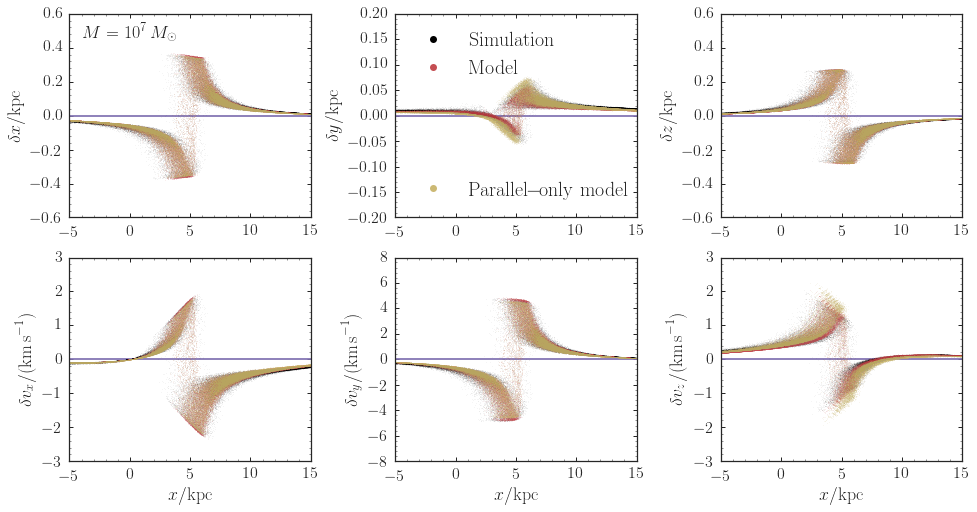

In [12]:
bovy_plot.bovy_print(axes_labelsize=18.,text_fontsize=12.,xtick_labelsize=16.,ytick_labelsize=16.)
figsize(16,8)
plot_single_comparison(xv_unp_peri,xv_1e7_peri,xv_mock_unp,xv_mock_per,xv_mock_per_onlyopar,7.)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','compare_nbody_single_1e7.pdf'),
                bbox_inches='tight')

## $10^6\,M_\odot$

In [13]:
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_2nd_peri_unperturbed.txt'))
xv_unp_peri= xvid[:,:6]
xv_unp_peri= xv_unp_peri[numpy.argsort(xvid[:,6])]
RvR_unp_peri= convert_to_cylindrical(xv_unp_peri)
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_880Myr_1e6Msun.txt'))
xv_1e6_peri= xvid[:,:6]
xv_1e6_peri= xv_1e6_peri[numpy.argsort(xvid[:,6])]
RvR_1e6_peri= convert_to_cylindrical(xv_1e6_peri)

In [14]:
sigv= 0.365*(10./2.)**(1./3.) # km/s, based on M^(1/3) scaling applied to 10^5 vs. 2x10^4 in my paper
sdf_smooth= \
    custom_stripping_df.streamdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                       leading=False,nTrackChunks=101,nTrackIterations=1,
                                       sigMeanOffset=4.5,
                                       tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                       Vnorm=V0,Rnorm=R0)
sdf_1e6= \
    custom_stripping_df.streamgapdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                          leading=False,nTrackChunks=101,nTrackIterations=1,
                                          nTrackChunksImpact=116,
                                          sigMeanOffset=4.5,
                                          tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          Vnorm=V0,Rnorm=R0,
                                          impactb=0.,
                                          subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0,
                                          timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          impact_angle=-2.34,
                                          GM=10.**-4./bovy_conversion.mass_in_1010msol(V0,R0),
                                          rs=0.08/R0)
sdf_1e6_onlyopar= \
    custom_stripping_df.streamgapdf_jason_onlyopar(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                          leading=False,nTrackChunks=101,nTrackIterations=1,
                                          nTrackChunksImpact=116,
                                          sigMeanOffset=4.5,
                                          tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          Vnorm=V0,Rnorm=R0,
                                          impactb=0.,
                                          subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0,
                                          timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          impact_angle=-2.34,
                                          GM=10.**-4./bovy_conversion.mass_in_1010msol(V0,R0),
                                          rs=0.08/R0)

In [15]:
numpy.random.seed(1)
xv_mock_unp= sdf_smooth.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per= sdf_1e6.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per_onlyopar= sdf_1e6_onlyopar.sample(n=100000,xy=True).T

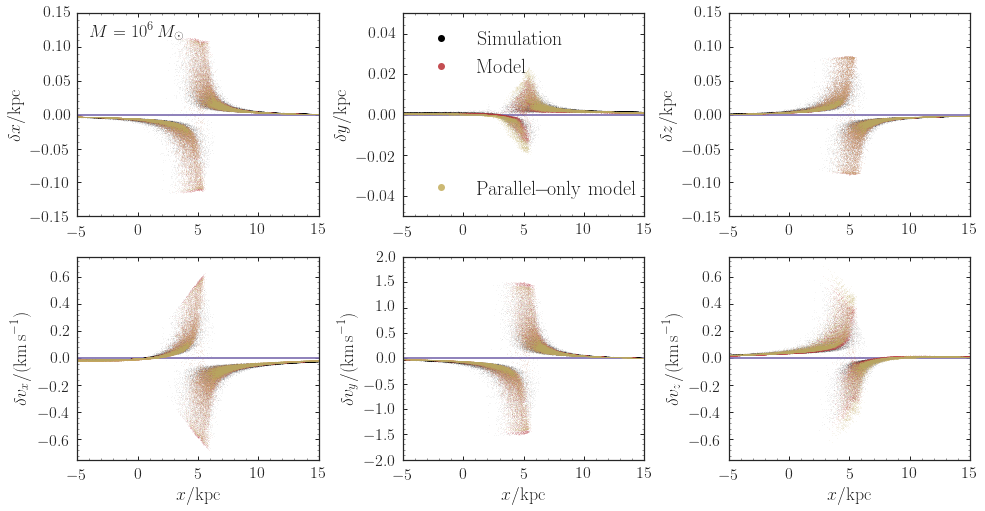

In [16]:
bovy_plot.bovy_print(axes_labelsize=18.,text_fontsize=12.,xtick_labelsize=16.,ytick_labelsize=16.)
figsize(16,8)
plot_single_comparison(xv_unp_peri,xv_1e6_peri,xv_mock_unp,xv_mock_per,xv_mock_per_onlyopar,6.)

## $10^5\,M_\odot$

In [17]:
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_2nd_peri_unperturbed.txt'))
xv_unp_peri= xvid[:,:6]
xv_unp_peri= xv_unp_peri[numpy.argsort(xvid[:,6])]
RvR_unp_peri= convert_to_cylindrical(xv_unp_peri)
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_880Myr_1e5Msun.txt'))
xv_1e5_peri= xvid[:,:6]
xv_1e5_peri= xv_1e5_peri[numpy.argsort(xvid[:,6])]
RvR_1e5_peri= convert_to_cylindrical(xv_1e5_peri)

In [18]:
sigv= 0.365*(10./2.)**(1./3.) # km/s, based on M^(1/3) scaling applied to 10^5 vs. 2x10^4 in my paper
sdf_smooth= \
    custom_stripping_df.streamdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                       leading=False,nTrackChunks=101,nTrackIterations=1,
                                       sigMeanOffset=4.5,
                                       tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                       Vnorm=V0,Rnorm=R0)
sdf_1e5= \
    custom_stripping_df.streamgapdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                          leading=False,nTrackChunks=101,nTrackIterations=1,
                                          nTrackChunksImpact=116,
                                          sigMeanOffset=4.5,
                                          tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          Vnorm=V0,Rnorm=R0,
                                          impactb=0.,
                                          subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0,
                                          timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          impact_angle=-2.34,
                                          GM=10.**-5./bovy_conversion.mass_in_1010msol(V0,R0),
                                          rs=0.04/R0)
sdf_1e5_onlyopar= \
    custom_stripping_df.streamgapdf_jason_onlyopar(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                          leading=False,nTrackChunks=101,nTrackIterations=1,
                                          nTrackChunksImpact=116,
                                          sigMeanOffset=4.5,
                                          tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          Vnorm=V0,Rnorm=R0,
                                          impactb=0.,
                                          subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0,
                                          timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          impact_angle=-2.34,
                                          GM=10.**-5./bovy_conversion.mass_in_1010msol(V0,R0),
                                          rs=0.04/R0)

In [19]:
numpy.random.seed(1)
xv_mock_unp= sdf_smooth.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per= sdf_1e5.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per_onlyopar= sdf_1e5_onlyopar.sample(n=100000,xy=True).T

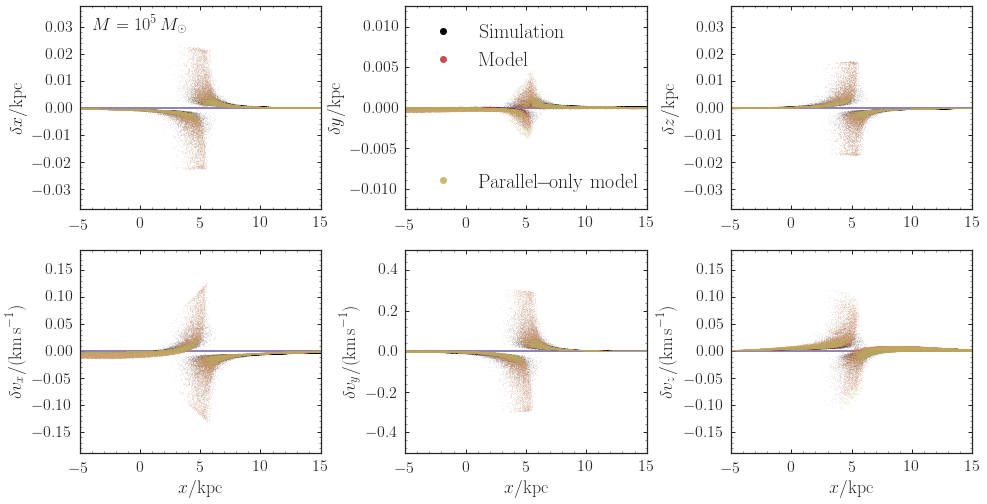

In [20]:
bovy_plot.bovy_print(axes_labelsize=18.,text_fontsize=12.,xtick_labelsize=16.,ytick_labelsize=16.)
figsize(16,8)
plot_single_comparison(xv_unp_peri,xv_1e5_peri,xv_mock_unp,xv_mock_per,xv_mock_per_onlyopar,5.)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','compare_nbody_single_1e5.pdf'),
                bbox_inches='tight')

# Multiple impacts

In [21]:
# Progenitor
xv_prog_init= numpy.array([30.,0.,0.,0., 105.74895, 105.74895])
RvR_prog_init= convert_to_cylindrical(xv_prog_init[:,numpy.newaxis].T)[0,:]
prog_init= Orbit([RvR_prog_init[0]/R0,RvR_prog_init[1]/V0,RvR_prog_init[2]/V0,
                  RvR_prog_init[3]/R0,RvR_prog_init[4]/V0,RvR_prog_init[5]],ro=R0,vo=V0)
times= numpy.linspace(0.,12./bovy_conversion.time_in_Gyr(V0,R0),1001)
prog_init.integrate(times,lp)
xv_unp_peri_prog= [prog_init.x(times[-1]),prog_init.y(times[-1]),prog_init.z(times[-1]),
              prog_init.vx(times[-1]),prog_init.vy(times[-1]),prog_init.vz(times[-1])]
RvR_unp_peri_prog= convert_to_cylindrical(numpy.array(xv_unp_peri_prog)[:,numpy.newaxis].T)[0,:]
prog_unp_peri= Orbit([RvR_unp_peri_prog[0]/R0,RvR_unp_peri_prog[1]/V0,RvR_unp_peri_prog[2]/V0,
                      RvR_unp_peri_prog[3]/R0+0.0,RvR_unp_peri_prog[4]/V0,RvR_unp_peri_prog[5]])

In [22]:
def plot_multi_comparison(xv_unp_peri,xv_1e6_peri,
                          xv_mock_unp,xv_mock_per,xv_mock_per_onlyopar,
                          log10mass,log10mass2,alpha=0.1):
    scale= 10.**(0.6*(log10mass-6.))
    gs=  gridspec.GridSpec(2,3,height_ratios=[1.,1.],hspace=0.2,wspace=0.35)
    gs2= gridspec.GridSpec(2,3,height_ratios=[1.,1.],hspace=0.2,wspace=0.35)
    subplot(gs2[0])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,1]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',color=sns.color_palette()[3],
                        ylabel=r'$\delta x/\mathrm{kpc}$',gcf=True,yrange=[-.08*scale,.08*scale],
                        xrange=[-14.,14.])
    plot(xv_unp_peri[(xv_unp_peri[:,0] < -10.),1],xv_1e6_peri[(xv_unp_peri[:,0] < -10.),0]
         -xv_unp_peri[(xv_unp_peri[:,0] < -10.),0],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per[:,0]-xv_mock_unp[:,0])*R0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per_onlyopar[:,0]-xv_mock_unp[:,0])*R0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    bovy_plot.bovy_text(r'$M = 10^%i\,M_\odot, M = 10^%i\,M_\odot$' % (log10mass,log10mass2),
                        size=18.,top_left=True)
    subplot(gs2[1])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,1]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',color=sns.color_palette()[3],
                        ylabel=r'$\delta y/\mathrm{kpc}$',gcf=True,yrange=[-.3*scale,.3*scale],
                        xrange=[-14.,14.])
    plot(xv_unp_peri[(xv_unp_peri[:,0] < -10.),1],xv_1e6_peri[(xv_unp_peri[:,0] < -10.),1]
         -xv_unp_peri[(xv_unp_peri[:,0] < -10.),1],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per[:,1]-xv_mock_unp[:,1])*R0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per_onlyopar[:,1]-xv_mock_unp[:,1])*R0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    l1= pyplot.legend((mlines.Line2D([], [], color='k',marker='o',ls='none'),
                       mlines.Line2D([], [], color=sns.color_palette()[2],marker='o',ls='none')),
                      (r'$\mathrm{Simulation}$',
                       r'$\mathrm{Model}$'),
                       loc='upper left',#bbox_to_anchor=(.02,.02),
                       numpoints=1,
                       prop={'size':20},
                       frameon=False)
    l2= pyplot.legend((mlines.Line2D([], [], color=sns.color_palette()[4],marker='o',ls='none'),),
                      (r'$\mathrm{Parallel\!\!-\!\!only\ model}$',),
                       loc='lower left',#bbox_to_anchor=(.02,.02),
                       numpoints=1,
                       prop={'size':20},
                       frameon=False)
    pyplot.gca().add_artist(l1)
    subplot(gs2[2])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,1]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',color=sns.color_palette()[3],
                        ylabel=r'$\delta z/\mathrm{kpc}$',gcf=True,yrange=[-.08*scale,.08*scale],
                        xrange=[-14.,14.])
    plot(xv_unp_peri[(xv_unp_peri[:,0] < -10.),1],xv_1e6_peri[(xv_unp_peri[:,0] < -10.),2]
         -xv_unp_peri[(xv_unp_peri[:,0] < -10.),2],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per[:,2]-xv_mock_unp[:,2])*R0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per_onlyopar[:,2]-xv_mock_unp[:,2])*R0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    subplot(gs2[3])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,1]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',xlabel=r'$y/\mathrm{kpc}$',color=sns.color_palette()[3],
                        ylabel=r'$\delta v_x/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-1.5*scale,1.5*scale],
                        xrange=[-14.,14.])
    plot(xv_unp_peri[(xv_unp_peri[:,0] < -10.),1],xv_1e6_peri[(xv_unp_peri[:,0] < -10.),3]
         -xv_unp_peri[(xv_unp_peri[:,0] < -10.),3],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per[:,3]-xv_mock_unp[:,3])*V0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per_onlyopar[:,3]-xv_mock_unp[:,3])*V0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    subplot(gs2[4])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,1]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',xlabel=r'$y/\mathrm{kpc}$',color=sns.color_palette()[3],
                        ylabel=r'$\delta v_y/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-0.35*scale,0.35*scale],
                        xrange=[-14.,14.])
    plot(xv_unp_peri[(xv_unp_peri[:,0] < -10.),1],xv_1e6_peri[(xv_unp_peri[:,0] < -10.),4]
         -xv_unp_peri[(xv_unp_peri[:,0] < -10.),4],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per[:,4]-xv_mock_unp[:,4])*V0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per_onlyopar[:,4]-xv_mock_unp[:,4])*V0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    subplot(gs2[5])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,1]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',xlabel=r'$y/\mathrm{kpc}$',color=sns.color_palette()[3],
                        ylabel=r'$\delta v_z/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-1.5*scale,1.5*scale],
                        xrange=[-14.,14.])
    plot(xv_unp_peri[(xv_unp_peri[:,0] < -10.),1],xv_1e6_peri[(xv_unp_peri[:,0] < -10.),5]
         -xv_unp_peri[(xv_unp_peri[:,0] < -10.),5],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per[:,5]-xv_mock_unp[:,5])*V0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per_onlyopar[:,5]-xv_mock_unp[:,5])*V0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)

## Two $10^8\,M_\odot$ impacts

In [23]:
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz',
                                 'snapshot_12000Myr_unperturbed.txt'))
xv_unp_12Gyr= xvid[:,:6]
xv_unp_12Gyr= xv_unp_12Gyr[numpy.argsort(xvid[:,6])]
RvR_unp_12Gyr= convert_to_cylindrical(xv_unp_12Gyr)
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz',
                                 'snapshot_1e8Msun_1e8Msun_impact_12000Myr.txt'))
xv_1e8_12Gyr= xvid[:,:6]
xv_1e8_12Gyr= xv_1e8_12Gyr[numpy.argsort(xvid[:,6])]
RvR_1e8_12Gyr= convert_to_cylindrical(xv_1e8_12Gyr)

In [24]:
reload(custom_stripping_df)

<module 'custom_stripping_df' from 'custom_stripping_df.pyc'>

In [25]:
sigv= 0.365*(10./2.)**(1./3.) # km/s, based on M^(1/3) scaling applied to 10^5 vs. 2x10^4 in my paper
sdf_smooth= \
    custom_stripping_df.streamdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
#                                       leading=False,nTrackChunks=101,nTrackIterations=1,
                                       leading=False,nTrackChunks=11,nTrackIterations=1,
                                       sigMeanOffset=4.5,
                                       tdisrupt=12./bovy_conversion.time_in_Gyr(V0,R0),
                                       Vnorm=V0,Rnorm=R0)
sdf_1e81e8= \
   custom_stripping_df.streampepperdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                            leading=False,nTrackChunks=101,nTrackIterations=1,
                                            nTrackChunksImpact=116,sigMeanOffset=4.5,
#                                            leading=False,nTrackChunks=11,nTrackIterations=1,
#                                            nTrackChunksImpact=11,sigMeanOffset=4.5,
                                            tdisrupt=12.00/bovy_conversion.time_in_Gyr(V0,R0),
                                            Vnorm=V0,Rnorm=R0,
                                            impactb=[0.,0.],
                                            subhalovel=numpy.array([[6.82200571,132.7700529,149.4174464],
                                                                    [100.,0.,0.]])/V0, # from Denis' email
                                            timpact=[2./bovy_conversion.time_in_Gyr(V0,R0),
                                                     1./bovy_conversion.time_in_Gyr(V0,R0)],
                                            impact_angle=[-2.34,-2.44],
                                            GM=[10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),
                                                10.**-2./bovy_conversion.mass_in_1010msol(V0,R0)],
                                            rs=[1.05/R0,1.05/R0])
sdf_1e81e8_onlyopar= \
   custom_stripping_df.streampepperdf_jason_onlyopar(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                            leading=False,nTrackChunks=101,nTrackIterations=1,
                                            nTrackChunksImpact=116,sigMeanOffset=4.5,
#                                            leading=False,nTrackChunks=11,nTrackIterations=1,
#                                            nTrackChunksImpact=11,sigMeanOffset=4.5,
                                            tdisrupt=12.00/bovy_conversion.time_in_Gyr(V0,R0),
                                            Vnorm=V0,Rnorm=R0,
                                            impactb=[0.,0.],
                                            subhalovel=numpy.array([[6.82200571,132.7700529,149.4174464],
                                                                    [100.,0.,0.]])/V0, # from Denis' email
                                            timpact=[2./bovy_conversion.time_in_Gyr(V0,R0),
                                                     1./bovy_conversion.time_in_Gyr(V0,R0)],
                                            impact_angle=[-2.34,-2.44],
                                            GM=[10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),
                                                10.**-2./bovy_conversion.mass_in_1010msol(V0,R0)],
                                            rs=[1.05/R0,1.05/R0]) 

In [26]:
sdf_1e81e8._useInterp= True
sdf_1e81e8_onlyopar._useInterp= True
numpy.random.seed(1)
xv_mock_unp= sdf_smooth.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per= sdf_1e81e8.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per_onlyopar= sdf_1e81e8_onlyopar.sample(n=100000,xy=True).T

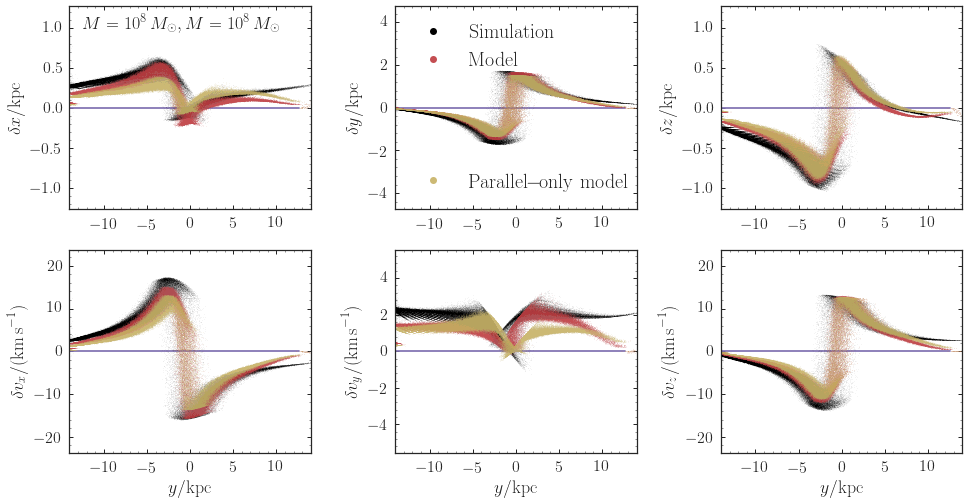

In [27]:
bovy_plot.bovy_print(axes_labelsize=18.,text_fontsize=12.,xtick_labelsize=16.,ytick_labelsize=16.)
figsize(16,8)
plot_multi_comparison(xv_unp_12Gyr,xv_1e8_12Gyr,xv_mock_unp,xv_mock_per,xv_mock_per_onlyopar,8.,8.)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','compare_nbody_multi_1e81e8.pdf'),
                bbox_inches='tight')

## One $10^8\,M_\odot$ and then one $10^7\,M_\odot$ impact

In [28]:
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz',
                                 'snapshot_12000Myr_unperturbed.txt'))
xv_unp_12Gyr= xvid[:,:6]
xv_unp_12Gyr= xv_unp_12Gyr[numpy.argsort(xvid[:,6])]
RvR_unp_12Gyr= convert_to_cylindrical(xv_unp_12Gyr)
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz',
                                 'snapshot_1e8Msun_1e7Msun_impact_12000Myr.txt'))
xv_1e7_12Gyr= xvid[:,:6]
xv_1e7_12Gyr= xv_1e7_12Gyr[numpy.argsort(xvid[:,6])]
RvR_1e7_12Gyr= convert_to_cylindrical(xv_1e7_12Gyr)

In [29]:
sigv= 0.365*(10./2.)**(1./3.) # km/s, based on M^(1/3) scaling applied to 10^5 vs. 2x10^4 in my paper
sdf_smooth= \
    custom_stripping_df.streamdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
#                                       leading=False,nTrackChunks=101,nTrackIterations=1,
                                       leading=False,nTrackChunks=11,nTrackIterations=1,
                                       sigMeanOffset=4.5,
                                       tdisrupt=12./bovy_conversion.time_in_Gyr(V0,R0),
                                       Vnorm=V0,Rnorm=R0)
sdf_1e81e7= \
   custom_stripping_df.streampepperdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                            leading=False,nTrackChunks=101,nTrackIterations=1,
                                            nTrackChunksImpact=116,sigMeanOffset=4.5,
#                                            leading=False,nTrackChunks=11,nTrackIterations=1,
#                                            nTrackChunksImpact=11,sigMeanOffset=4.5,
                                            tdisrupt=12.00/bovy_conversion.time_in_Gyr(V0,R0),
                                            Vnorm=V0,Rnorm=R0,
                                            impactb=[0.,0.],
                                            subhalovel=numpy.array([[6.82200571,132.7700529,149.4174464],
                                                                    [100.,0.,0.]])/V0, # from Denis' email
                                            timpact=[2./bovy_conversion.time_in_Gyr(V0,R0),
                                                     1./bovy_conversion.time_in_Gyr(V0,R0)],
                                            impact_angle=[-2.34,-2.44],
                                            GM=[10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),
                                                10.**-3./bovy_conversion.mass_in_1010msol(V0,R0)],
                                            rs=[1.05/R0,1.05/R0])
sdf_1e81e7_onlyopar= \
   custom_stripping_df.streampepperdf_jason_onlyopar(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                            leading=False,nTrackChunks=101,nTrackIterations=1,
                                            nTrackChunksImpact=116,sigMeanOffset=4.5,
#                                            leading=False,nTrackChunks=11,nTrackIterations=1,
#                                            nTrackChunksImpact=11,sigMeanOffset=4.5,
                                            tdisrupt=12.00/bovy_conversion.time_in_Gyr(V0,R0),
                                            Vnorm=V0,Rnorm=R0,
                                            impactb=[0.,0.],
                                            subhalovel=numpy.array([[6.82200571,132.7700529,149.4174464],
                                                                    [100.,0.,0.]])/V0, # from Denis' email
                                            timpact=[2./bovy_conversion.time_in_Gyr(V0,R0),
                                                     1./bovy_conversion.time_in_Gyr(V0,R0)],
                                            impact_angle=[-2.34,-2.44],
                                            GM=[10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),
                                                10.**-3./bovy_conversion.mass_in_1010msol(V0,R0)],
                                            rs=[1.05/R0,0.332/R0]) 

In [30]:
sdf_1e81e7._useInterp= True
sdf_1e81e7_onlyopar._useInterp= True
numpy.random.seed(1)
xv_mock_unp= sdf_smooth.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per= sdf_1e81e7.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per_onlyopar= sdf_1e81e7_onlyopar.sample(n=100000,xy=True).T

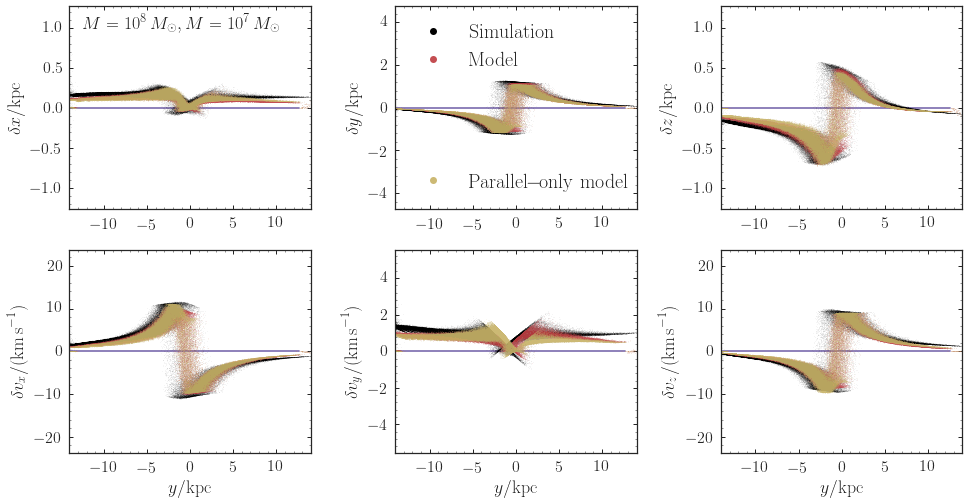

In [31]:
bovy_plot.bovy_print(axes_labelsize=18.,text_fontsize=12.,xtick_labelsize=16.,ytick_labelsize=16.)
figsize(16,8)
plot_multi_comparison(xv_unp_12Gyr,xv_1e7_12Gyr,xv_mock_unp,xv_mock_per,xv_mock_per_onlyopar,8.,7.)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','compare_nbody_multi_1e81e7.pdf'),
                bbox_inches='tight')